#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Embeddings

Embeddings are a powerful way to represent data for deep learning (neural network) models. They transform categorical data into efficient, dense vectors that capture similarities between items.

In this exercise we will work specifically with embeddings of words, one of the most common applications of this technique. We will train word embeddings from scratch on a small dataset and visualize those embeddings.

---

<img height="20px" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Tensorflow_logo.svg" align="left" hspace="10px">
This lab is developed based on [TensorFlow.org's Word embeddings](https://www.tensorflow.org/alpha/tutorials/sequences/word_embeddings).

## Overview

### Learning Objectives

* Understand what embeddings are, why they are used, how they are trained
* Use embeddings in practice

### Prerequisites

* Introduction to Neural Networks
* Introduction to Keras

### Estimated Duration

45 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There are 4 exercises in this Colab so there are 12 points available. The grading scale will be 9 points.

# Learn embeddings



Embeddings can be trained using either supervised or unsupervised learning, but always with a specific problem context in mind. The learned embeddings are thus tailored for the desired task. For this exercise, we will train a supervised sentiment classifier on IMDB movie reviews. In the process, we will learn our own word embeddings.

### Setup

First, we will set random seeds for reproducible results. This makes sure that we get the same results everytime we run this Colab by controlling how any random numbers are generated.

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.set_random_seed(42)

## Data and Problem

We will use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). This dataset is conveniently packaged in Keras. 

In [3]:
from tensorflow import keras

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(index_from=2)

17465344/17464789 [==============================] - 1s 0us/step


The reviews have been pre-processed so that the text of each review (a list of words) has been converted to a list of integers, where each integer represents a specific word. We set the smallest word index as 3 (`index_from=2`) to handle some special tokens, which we'll describe in the next section.

Each sentiment label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review. Thus this is a binary classification problem.

In [4]:
print(train_data[0])

[1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 22664, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 21630, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 19192, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 10310, 7, 3, 106, 116, 5951, 14, 255, 3, 31049, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 12117, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


### Convert the integers back to words

It may be useful to know how to convert a list of integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [5]:
# A dictionary mapping each word to an integer index
word_index = imdb.get_word_index()

# Reserve the first 3 indices for special tokens
word_index = {k:(v+2) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

vocab_size = len(word_index)
print('# unique words: {}'.format(vocab_size))

1646592/1641221 [==============================] - 0s 0us/step
# unique words: 88587


In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

### Preprocessing

Notice that there are three special tokens in the `word_index` dictionary. `"<START>"` marks the beginning of each review. `"<UNK>"` handles "unknown" words, or words that appear in the test dataset but not in the training dataset (so they are effectively "unknown" to the model). 

Finally, movie reviews can be different lengths, but inputs to a neural network must all be the same length. Let's take a look at the distribution of review lengths.

In [7]:
import matplotlib.pyplot as plt

review_lengths = [len(review) for review in train_data]
plt.hist(review_lengths, normed=True, cumulative=True)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()

/Users/dorishuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


<Figure size 640x480 with 1 Axes>

Even though the longest review is close to 2500 words long, over 90% of the reviews have fewer than 500 words. 

We can use the `pad_sequences` function to standardize the lengths of the reviews to 500 words long. Any reviews longer than this will have the extra words truncated, while any reviews shorter will have extra `"<PAD>"` tokens added to the end. 

Choosing a standardized length requires balancing efficiency (longer lengths mean slower training) and information loss (shorter lengths may truncate too much valuable information). Aiming for a length that fully covers 90% of samples is generally reasonable, and you can further tune this as a hyperparameter.

In [8]:
maxlen = 500

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

Let's inspect the first padded review.

In [9]:
print(train_data[0])

[    1    13    21    15    42   529   972  1621  1384    64   457  4467
    65  3940     3   172    35   255     4    24    99    42   837   111
    49   669 22664     8    34   479   283     4   149     3   171   111
   166 21630   335   384    38     3   171  4535  1110    16   545    37
    12   446     3   191    49    15     5   146  2024    18    13    21
     3  1919  4612   468     3    21    70    86    11    15    42   529
    37    75    14    12  1246     3    21    16   514    16    11    15
   625    17 19192     4    61   385    11     7   315     7   105     4
     3  2222  5243    15   479    65  3784    32     3   129    11    15
    37   618     4    24   123    50    35   134    47    24  1414    32
     5    21    11   214    27    76    51     4    13   406    15    81
 10310     7     3   106   116  5951    14   255     3 31049     6  3765
     4   722    35    70    42   529   475    25   399   316    45     6
     3 12117  1028    12   103    87     3   380   

## Build the Model

### Using the Embedding layer

Keras makes it easy to use embeddings. The [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes at least two arguments: the number of possible words in the vocabulary and the dimensionality of the embeddings. We will start by using a small embedding size of 2 to make visualization easier.

In [10]:
embedding_dim = 2

embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim)

W0809 19:19:46.379709 4478375360 deprecation.py:506] From /Users/dorishuang/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

When we create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem our model is trained on).

As input, the Embedding layer takes a 2D tensor of integers, of shape `(num_samples, sequence_length)`, where each sample is a sequence of integers. As output, the embedding layer returns a 3D floating point tensor, of shape `(num_samples, sequence_length, embedding_dimensionality)`. 

### Configure the Model

* The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch size, sequence length, embedding size)`.

* Next, we flatten the output from a 2-d array to a 1-d array.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [11]:
model = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

W0809 19:19:46.397419 4478375360 deprecation.py:506] From /Users/dorishuang/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 2)            177174    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 178,175
Trainable params: 178,175
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [12]:
model.compile(

  # Calculate loss for a binary classification problem
  loss='binary_crossentropy',

  # Adam is one of the most commonly used optimizers
  optimizer=tf.train.AdamOptimizer(),

  # We will only track accuracy for this task
  metrics=['accuracy']

)

W0809 19:19:46.570213 4478375360 deprecation.py:323] From /Users/dorishuang/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The number of epochs and batch size used during training are both hyperparameters, meaning you may need to experiment with different values to improve performance. This also means there's no magic answer for what values to choose.

If you've implemented your model correctly, you should observe decreasing training loss within a few epochs. With more epochs (more training), the model will experience more overfitting. You will typically train for at least 5 epochs -- for this model, we train for 10 epochs as a reasonable tradeoff between learning (as the validation accuracy is still increasing) and overfitting.

Since we have a fairly large dataset, we also want to process data in batches instead of the entire dataset at once. Too small batch sizes lead to slower training per epoch, while too large batch sizes may require more epochs to train and even cause out-of-memory errors. It's good practice to start with a small power of two (e.g. 32), then experiment with continuously doubling your batch size. For this model, we are able to use a batch size of 512 with good performance.

In [13]:
# Train the model
history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 40us/sample - loss: 0.6930 - acc: 0.5087 - val_loss: 0.6921 - val_acc: 0.5168
Epoch 2/10
20000/20000 [==============================] - 1s 34us/sample - loss: 0.6871 - acc: 0.5814 - val_loss: 0.6881 - val_acc: 0.5322
Epoch 3/10
20000/20000 [==============================] - 1s 39us/sample - loss: 0.6726 - acc: 0.6758 - val_loss: 0.6669 - val_acc: 0.6682
Epoch 4/10
20000/20000 [==============================] - 1s 39us/sample - loss: 0.6297 - acc: 0.7448 - val_loss: 0.6106 - val_acc: 0.7370
Epoch 5/10
20000/20000 [==============================] - 1s 33us/sample - loss: 0.5525 - acc: 0.7978 - val_loss: 0.5341 - val_acc: 0.7792
Epoch 6/10
20000/20000 [==============================] - 1s 45us/sample - loss: 0.4662 - acc: 0.8389 - val_loss: 0.4646 - val_acc: 0.8186
Epoch 7/10
20000/20000 [==============================] - 1s 34us/sample - loss: 0.3925 - acc: 0.8732 - val_loss: 0.4

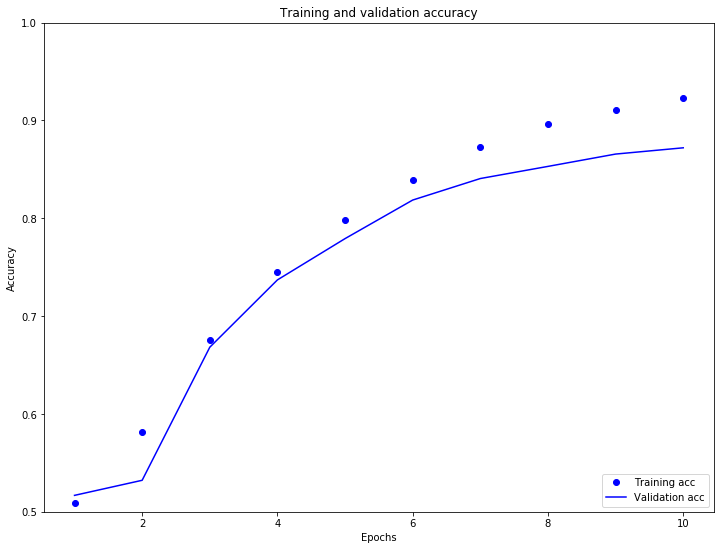

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))

plt.show()

With this approach our model reaches a validation accuracy of around 87% (note that the model is already beginning to overfit, as reflected in the diverging training and validation accuracy curves).

# Visualize embeddings

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab size, embedding dimension)`.

In [15]:
e = model.layers[0]
embedding_matrix = e.get_weights()[0]
print(embedding_matrix.shape)

(88587, 2)


Let's explore the learned word embeddings on a small set of terms (looking at all 80,000+ at once would be overwhelming). Most of these terms are generally strongly indicative of sentiment, but some are added just for fun.

In [16]:
informative_terms = [ "bad", "great", "best", "worst", "fun", "beautiful",
                      "excellent", "poor", "boring", "awful", "terrible",
                      "definitely", "perfect", "liked", "worse", "waste",
                      "entertaining", "loved", "unfortunately", "amazing",
                      "enjoyed", "favorite", "horrible", "brilliant", "highly",
                      "simple", "annoying", "today", "hilarious", "enjoyable",
                      "dull", "fantastic", "poorly", "fails", "disappointing",
                      "disappointment", "not", "him", "her", "good", "time",
                      "sad", "exciting", "slow", "movie", "film", "action",
                      "comedy", "drama", "fabulous"]

Now we plot each word in `informative_terms` on a 2-dimensional graph. Recall that we are using 2-dimensional embeddings, so consider the 1st value as an x-value and the 2nd value as a y-value. 

*Note: if the displayed plot is too small, try running the cell again.*

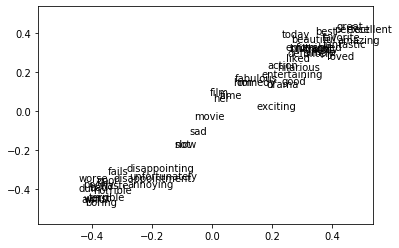

In [17]:
for word in informative_terms:
  word_num = word_index[word]
  embeddings = embedding_matrix[word_num]
  plt.text(embeddings[0], embeddings[1], word)

# Do a little set-up to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (25, 25)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show()

# Exercises

## Exercise 1

What structures do you see in the embeddings of the words?

### Student Solution

The movie is the netural word for either possitive or negative reviews since it's about movie reviews. Negative sentiments are gathered in the lower left cornor with lower y values. Positive feedback sentiments are gathered in the upper right corner with higher y values. Some random words like 'her, time' get scores just a little higher than movie.   



## Exercise 2: Higher-dimensional embeddings

Now we can visualize 2-dimensional embeddings, but recall that our original vocabulary had over 80,000 words -- we're missing a lot of information if we only use 2 dimensions!

Typical embedding dimensions are 50, 100, 200, 300, and sometimes even larger. In this section we'll introduce the [Embedding Projector](http://projector.tensorflow.org/), a tool to visualize high-dimensional embeddings.

Re-train our earlier model, with the same hyperparameters, using **50-dimensional** embeddings and retrieve the learned embeddings from this trained model. You should observe a slower training time and much higher training accuracy after 10 epochs.

### Student Solution

In [18]:
# Re-train model using 50-dimensional embeddings
embedding_dim = 50
embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim)

In [19]:
model = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           4429350   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25001     
Total params: 4,454,351
Trainable params: 4,454,351
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
  loss='binary_crossentropy',
  optimizer=tf.train.AdamOptimizer(),
  metrics=['accuracy']
)

In [21]:
# Train the model
history = model.fit(
    train_data,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 203us/sample - loss: 0.6871 - acc: 0.5578 - val_loss: 0.6577 - val_acc: 0.6956
Epoch 2/10
20000/20000 [==============================] - 4s 190us/sample - loss: 0.5466 - acc: 0.7983 - val_loss: 0.4617 - val_acc: 0.8172
Epoch 3/10
20000/20000 [==============================] - 4s 186us/sample - loss: 0.3256 - acc: 0.8945 - val_loss: 0.3422 - val_acc: 0.8664
Epoch 4/10
20000/20000 [==============================] - 4s 190us/sample - loss: 0.2053 - acc: 0.9405 - val_loss: 0.3130 - val_acc: 0.8742
Epoch 5/10
20000/20000 [==============================] - 3s 163us/sample - loss: 0.1393 - acc: 0.9660 - val_loss: 0.2858 - val_acc: 0.8886
Epoch 6/10
20000/20000 [==============================] - 3s 170us/sample - loss: 0.0975 - acc: 0.9810 - val_loss: 0.2801 - val_acc: 0.8894
Epoch 7/10
20000/20000 [==============================] - 3s 161us/sample - loss: 0.0699 - acc: 0.9890 - val_lo

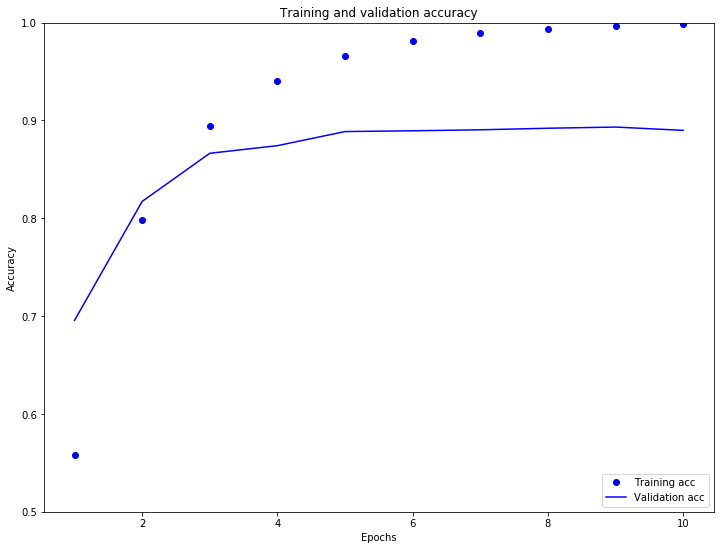

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))

plt.show()

In [23]:
e = model.layers[0]
embedding_matrix = e.get_weights()[0]
print(embedding_matrix.shape)

(88587, 50)


In [24]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word in informative_terms:
  word_num = word_index[word]
  embeddings = embedding_matrix[word_num]
# for compatibility with python 2 and 3
  out_m.write(word.encode("utf-8").decode("utf-8") + "\n")
  out_v.write('\t'.join([str(x).encode("utf-8").decode("utf-8") for x in embeddings]) + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Exercise 3

How do the structures of these embeddings compare to the 2-dimensional embeddings we visualized earlier? How do the model accuracies compare? What might this suggest about the effect of increasing embedding size?

### Student Solution

The strong sentiments words are more closely gathered together while other netural or random words tend to spread more across the dimenstions. 

The training accurancies is much higher compared to 2-dimensional embeddings. But the validation accurancy appears to overfit after 3 epoches. 

Increasing embedding size will create more accurate training accurancies but the overfit problem will appear sooner than a smaller accurate embedding size. 



## Exercise 4: Beyond word embeddings

The Embedding layer in Keras makes it easy to represent any data that has an index-based lookup. What are some other kinds of data (besides words) that this could be useful for?

On the flip side, what are some kinds of data that don't work as well with an index-based lookup? Let's say we still want to achieve the advantages of using embeddings, namely transforming this data into 1) efficient, dense vectors that 2) capture similarities between data. How could we do this?

### Student Solution

Since it's easy to represent any data that has an index-based lookup, categorical data representation could benefit. 

Image data don't work as well with an index-based lookup since image will be in pixel array representations. Each index can not represent the image or help with finding correlations.

We can label the image according to the objects in the image and only use the labels to the the embeddings instead of the whole image. 

